In [2]:
#%%
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *
import seaborn as sns

folder_path = '../experiment_data/tk_03272024'

exp_layout = {0:(0,['B','C','D']),
              10**-2:(0,['E','F','G']),
              10**-1:(1,['B','C','D']),
              10**0:(1,['E','F','G']),
              10**1:(2,['B','C','D']),
              10**2:(2,['E','F','G'])}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

In [3]:
def get_timeseries(folder_path,plate_num):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [4]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder_path,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t,background_subtracted=False)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

dict_t = {'time':time,
          'mean':mean_dict,
          'err':err_dict,
          'cell_count_mean':cell_count_mean,
          'cell_count_err':cell_count_err,
          'cell_count_log_err':cell_count_log_err}

# save as pickle

with open('data_11092023.pickle','wb') as f:
    pickle.dump(dict_t,f)


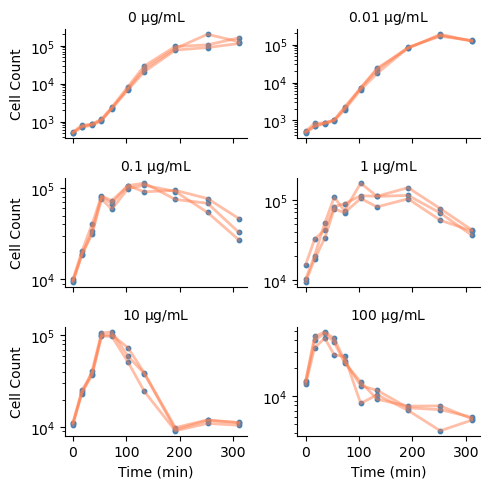

In [5]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,figsize=(5,5),sharex=True)
ax_list = ax_list.flatten()

row_indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[row_indx]
    cell_count_t = cell_count_raw[key]

    for i in range(3):
        ax.scatter(time,cell_count_t[i,:],color='steelblue',alpha=1,s=10)
        ax.plot(time,cell_count_t[i,:],color='coral',alpha=0.5,linewidth=2)
        
    # ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key],fmt='o',label=key)
    # ax.scatter(time,mean_dict[key],label=key)
    # ax.set_xscale('log')
    ax.set_title(str(key) + ' $\mathrm{\mu}$g/mL',fontsize=10)
    ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    row_indx += 1

ax_list[4].set_xlabel('Time (min)')
ax_list[5].set_xlabel('Time (min)')

ax_list[0].set_ylabel('Cell Count')
ax_list[2].set_ylabel('Cell Count')
ax_list[4].set_ylabel('Cell Count')
fig.tight_layout()

# for ax in ax_list[2:]:
    # ax.set_ylim(10**4,10**6)

fig.savefig('../../figures/time_kill_03272024_cell_count.pdf',bbox_inches='tight')

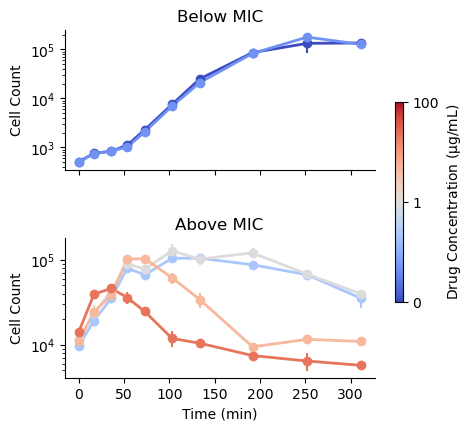

In [31]:
# cmap = sns.color_palette("colorblind", as_cmap=True)
# vridis colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

n_replicates = 3

fig,ax_list = plt.subplots(nrows=2,figsize=(4,4),sharex=True)

for j,key in enumerate(cell_count_mean.keys()):

    cell_count_t = np.zeros((n_replicates,len(time)))
    for i in range(n_replicates):
        # cell_count_t[i,:] = cell_count_raw[key][i]/cell_count_raw[key][i,0]
        cell_count_t[i,:] = cell_count_raw[key][i]
        # ax.plot(time,cell_count_t,color=cmap[j])
    
    # mean
    cell_count_mean_t = np.mean(cell_count_t,axis=0)

    # err
    # cell_count_err_t = np.std(cell_count_t,axis=0)/np.sqrt(n_replicates)
    cell_count_err_t = np.std(cell_count_t,axis=0)

    if j < 2:
        ax = ax_list[0]
    else:
        ax = ax_list[1]

    ax.errorbar(time,cell_count_mean_t,yerr=cell_count_err_t,fmt='o',color=cmap(j/6),label=key)
    ax.plot(time,cell_count_mean_t,color=cmap(j/6),alpha=1,linewidth=2)

    ax.set_yscale('log')

    row_indx += 1

for ax in ax_list:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

cax = fig.add_axes([0.95, 0.2, 0.02, 0.5])
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap),ax=ax,cax=cax)
cbar.set_ticks([0,0.5,1])
cbar.set_ticklabels([0,1,10**2])
cbar.set_label('Drug Concentration ($\mathrm{\mu}$g/mL)')

ax_list[1].set_xlabel('Time (min)')
ax_list[0].set_ylabel('Cell Count')
ax_list[1].set_ylabel('Cell Count')

pos = ax_list[1].get_position()
width = pos.width

pos = ax_list[0].get_position()
pos.x1 = pos.x0 + width
ax_list[0].set_position(pos)

ax_list[0].set_title('Below MIC')
ax_list[1].set_title('Above MIC')

pos = ax_list[1].get_position()

pos.y0 = pos.y0 - 0.1
pos.y1 = pos.y1 - 0.1

ax_list[1].set_position(pos)

fig.savefig('../../figures/time_kill_03272024_cell_count_mean.pdf',bbox_inches='tight')
